# Notebook 0: Spatial Basis Functions

We will nearly always need `numpy` and `matplotlib` when writing notebooks.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3

## Spatial Setup

In Dedalus, regardless of whether or not you have time derivatives, you will need to set up a spatial domain. This requires at least three things:

1. a coordinate system
2. a distributor to coordiate parallel computation (but you need even in serial calculation)
3. a basis

Here, we choose the simplest system: a one-dimensional Cartesian system

In [2]:
nx = 64 # number of coefficients


xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=np.float64)
xbasis = d3.RealFourier(xcoord, nx, bounds=(-np.pi,np.pi), dealias=1)

Now, let's define a `Field`. Fields are created by the distributor object and hold our problem data. Let's create a scalar field called `T`.

In [3]:
# Fields
T = dist.Field(name='T', bases=xbasis)

One of the key points of Dedalus is that once you've chosen a basis and a coordinate system, all data objects can be represented either as a finite set of **grid point** values, accessed via
```
T['g'] # for grid
```
or as a set of **coefficients** representing the projection of that data onto the basis functions, accessed via
```
T['c'] # for coefficient
```

In order to add data, we could first do the simplest thing: set all values to one:

In [4]:
T['g'] = 1

Note that if we simply print the data, we get what we expect:

In [5]:
print(T['g'])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Exercise ###

Predict what the coefficient data should look like for this. Once you've got an idea, run the next cell.

In [6]:
T['c']

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,
        0., -0.,  0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,
        0., -0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.,  0., -0.])

Now, it's clear that the first coefficient is 1 and all of the others are zero, but at higher resolutions, orinting the data is a bad way to confirmthis. There are several better ways, but probably the simplest is to **plot** the coefficients:

Text(0, 0.5, "T['c']")

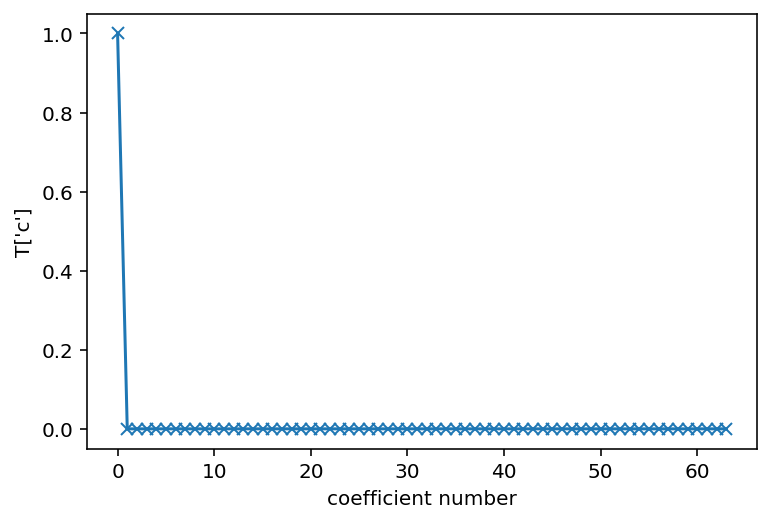

In [7]:
plt.plot(T['c'], 'x-')
plt.xlabel("coefficient number")
plt.ylabel("T['c']")

We've already learned quite a bit about this data, but let's dig a bit deeper. 

First, how big is the data? The grid and coefficient data will appear as numpy `ndarray` objects (the standard numpy data object), with a data type that will typically be either `float64` or `complex128`. Let's look at their sizes:

In [8]:
print(f"Coefficent shape: {T['c'].shape}")
print(f"Grid shape: {T['g'].shape}")

Coefficent shape: (64,)
Grid shape: (64,)


The first thing to note is that the number of coefficients is the same as the number of grid points. This is interesting! Let's dig in a bit more.

The next thing to note is that the coefficients are **real numbers**, despite the fact that they represent the Fourier transform of the original data. This is because we have chosen the `RealFourier` basis, asserting that our original grid data is real. Of course, not all data we want to solve PDEs for is real, and Dedalus can handle this too, using `ComplexFourier`. 

Next, let's add a function of the grid points, something like

$$
T(x) = \sin(x),
$$

which, given that the bounds on our `RealFourier` basis are $0$ and $2\pi$, should give us one complete sine wave.

Each Dedalus basis provides the locations of each of its grid points. We will access them here using the `Distributor` object's `.local_grid()` function. The "local" here referrs to the fact that if you run your code in parallel, different processors will have different pieces of the grid, but every processor runs **the exact same code**. 

In [9]:
x = dist.local_grid(xbasis)

In [10]:
T['g'] = # insert something here

SyntaxError: invalid syntax (902300111.py, line 1)

Now, let's plot the data on the grid.

In [ ]:
plt.plot(x, T['g'])
plt.xlabel('x')
plt.ylabel("T['g']")

### Exercise ###
Using your knowledge of Fourier transforms, predict what the coefficients in `T['c']` should look like.

In [ ]:
T['c']

Use the code below to plot it.

In [ ]:
plt.plot(T['c'],'x')
plt.xlabel("coefficient number")
plt.ylabel("T['c']")

Teach `.allclose()` and concepts around it

### Exercise ###

Now try a more complex function of $\sin$ and $\cos$, 

$$
T(x) = 2 \cos(x) - \sin(x).
$$

**Before you code this up, predict what `T['c']` will be.**

After you've made your prediction, plot the coefficients. 

## Chebyshev polynomials

Now, let's move on to something more complicated. Let's look at our simple $\sin$ function, but now on a Chebyshev basis.

We'll create another distributor and basis function:

In [11]:
nx = 64 # number of coefficients

c_dist = d3.Distributor(xcoord, dtype=np.float64)
c_xbasis = d3.Chebyshev(xcoord, nx, bounds=(-np.pi,np.pi), dealias=1)

...and a new field. Make sure to get the right $x$ points! The grid for the Chebyshev and Fourier bases are different!

In [38]:
# Fields
xc = c_dist.local_grid(c_xbasis)
Tc = c_dist.Field(name='T', bases=c_xbasis)

Let's look at the grid points. Note here I'm only plotting every other point to make the grid structure more clear.

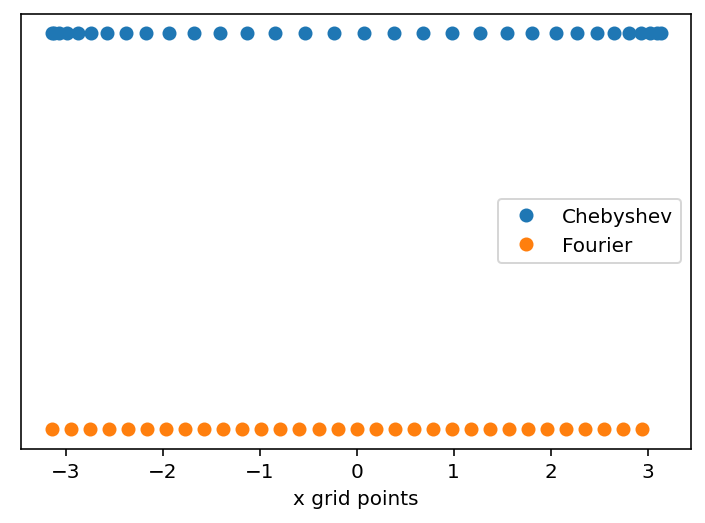

In [56]:
plt.plot(xc[::2],np.ones_like(xc[::2]),'o', label='Chebyshev')
plt.plot(x[::2],np.zeros_like(x[::2]),'o', label='Fourier')
plt.legend()
plt.xlabel("x grid points")
axes = plt.gca()
axes.get_yaxis().set_visible(False)

Now we'll put $\sin(x)$ on the field defined on a Chebyshev basis

In [45]:
Tc['g'] = np.sin(xc)

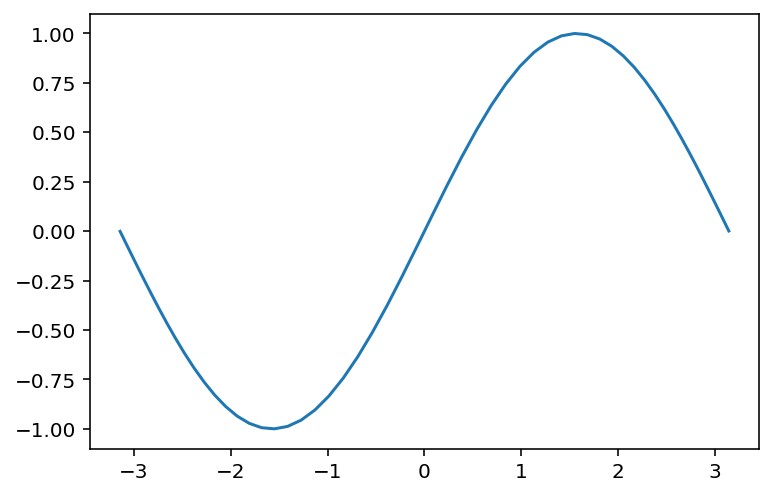

In [46]:
plt.plot(xc,Tc['g'])

And finally, we can plot the coefficients:

Text(0.9, 0.7, 'Roundoff plateau')

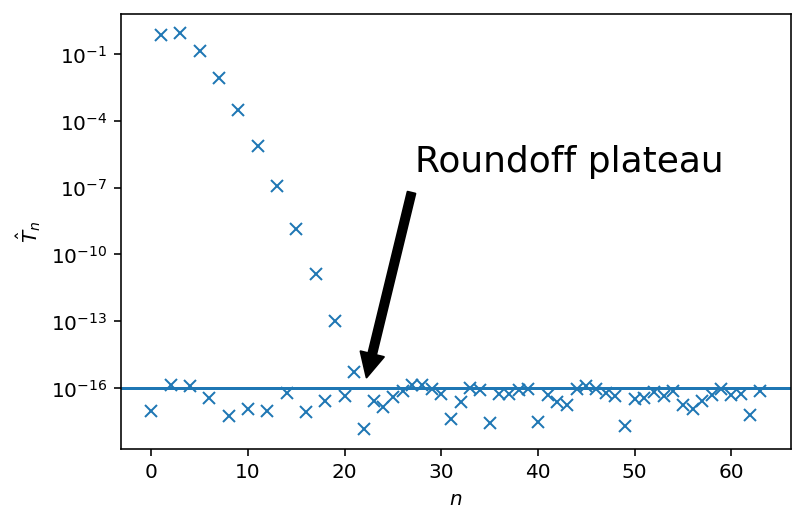

In [82]:
plt.semilogy(np.abs(Tc['c']),'x')
plt.xlabel(r"$n$")
plt.ylabel(r"$\hat{T}_n$")
plt.axhline(1e-16)
plt.annotate('Roundoff plateau', xy=(22, 1e-16),  xycoords='data',
            xytext=(0.9, 0.7), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=18,
            horizontalalignment='right', verticalalignment='top',
            )

Cool numpy trick if you perform a logical operation on a numpy array, you get back a **boolean** array, which you can simply sum (numpy will treat True as 1 and False as zero) to get the count of coefficients above some threshold value.

In [65]:
eps = 1e-15
coeff_above_thresh = np.abs(Tc['c'])> eps
print(f"{coeff_above_thresh[0:3]:}...") # just the first few

non_zero_count = np.sum(coeff_above_thresh)
print(f"There are {non_zero_count:} Chebyshev T coefficients above epsilon = {eps:5.2e}" )

[False  True False]...
There are 10 Chebyshev T coefficients above epsilon = 1.00e-15


Note we need ten coefficients in Chebyshev polynomials to represent something that takes only one in Fourier. **This is not a disadvantage of Chebyshev! Of course a sin (or cos) will have a single projection in a basis of those functions!**